In [9]:
!cat /proc/meminfo

MemTotal:       32949048 kB
MemFree:        16748232 kB
MemAvailable:   18404860 kB
Buffers:          668088 kB
Cached:          1190244 kB
SwapCached:            0 kB
Active:         15034124 kB
Inactive:         772496 kB
Active(anon):   13948324 kB
Inactive(anon):       48 kB
Active(file):    1085800 kB
Inactive(file):   772448 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               100 kB
Writeback:             0 kB
AnonPages:      13948420 kB
Mapped:           155904 kB
Shmem:                60 kB
Slab:             285948 kB
SReclaimable:     262288 kB
SUnreclaim:        23660 kB
KernelStack:        4208 kB
PageTables:        32920 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    16474524 kB
Committed_AS:   15537712 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
AnonHugePages:         0 kB
ShmemHugePages:  

In [2]:
!pip install xgboost

    100% |████████████████████████████████| 15.8MB 3.2MB/s eta 0:00:01
distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import io
import time
import json
import gc

from sklearn import preprocessing as prp
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import (accuracy_score, r2_score, confusion_matrix,
f1_score, recall_score, precision_score)

import os
import boto3
import re

import xgboost as xgb

# ruta de trabajo en s3
bucket = 'boi-banregio'

target = 'BMI'
seed = 0

# s3 resource
s3_bucket_resource = boto3.resource('s3').Bucket(bucket)

In [21]:
from itertools import chain, zip_longest

def predict(probs, threshold):
    preds = []
    for prob in probs:
        if prob > threshold:
            preds.append(1)
        else:
            preds.append(0)
    return np.array(preds)

# fval for hyperparameters
def val_func(pred_probs, dmat):
    thrs = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
    ret = []
    for thr in thrs:
        preds = predict(pred_probs, thr)
        score = f1_score(preds, dmat.get_float_info('label'))
        ret.append(('f1_score_thr{}'.format(thr), score))
    return ret

def val_func_thr(bst, dtest, test_y):
    f1_sc = 0
    max_step = 0
    thr_sample = (dtest, test_y)
    _score_preds = bst.predict(thr_sample[0])
    for thr_step in np.linspace(0, 1, 101):
        _preds = predict(_score_preds, thr_step)
        f1_sc_step = f1_score(thr_sample[1], _preds)        
        if f1_sc_step >= f1_sc:
            f1_sc = f1_sc_step
            max_step = thr_step
    # threshold = max_step
    return max_step, f1_sc  # threshold, f1score max value

def pretty_table(matrix):
    matrix_aux = chain.from_iterable(
        zip_longest(
            *(x.splitlines() for x in y),
            fillvalue='')
        for y in [[str(e) for e in row] for row in matrix])

    s = [[str(e) for e in row] for row in matrix_aux]
    lens = [max(map(len, col)) for col in zip(*s)]
    fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
    table = [fmt.format(*row) for row in s]
    print('\n'.join(table))
    
def get_xgb_feat_importances(clf):
    if isinstance(clf, xgb.XGBModel):
        # clf has been created by calling
        # xgb.XGBClassifier.fit() or xgb.XGBRegressor().fit()
        fscore = clf.booster().get_fscore()
    else:
        # clf has been created by calling xgb.train.
        # Thus, clf is an instance of xgb.Booster.
        fscore = clf.get_fscore()

    feat_importances = []
    for ft, score in fscore.items():
        feat_importances.append({'Feature': ft, 'Importance': score})
    feat_importances = pd.DataFrame(feat_importances)
    feat_importances = feat_importances.sort_values(
        by='Importance', ascending=False).reset_index(drop=True)
    # Divide the importances by the sum of all importances
    # to get relative importances. By using relative importances
    # the sum of all importances will equal to 1, i.e.,
    # np.sum(feat_importances['importance']) == 1
    feat_importances['Importance'] /= feat_importances['Importance'].sum()
    # Print the most important features and their importances
    print(feat_importances.head())
    return feat_importances

In [3]:
# Aquí colocamos la ruta de nuestro directorio, el nombre de nuestro archivo y si tiene o no cabecera
prefix = 'datalake/data/InteligenciaRiesgos/M&M/MCV/DATASETS_3/JAT_MCV_VAR_VARIABLES_SELECCION/PARTITION'

In [5]:
rfc_key_features_file_name = "EXTRA_FEATURES/MCV_VAR_RFC_FECHA_LLAVE.csv"
rfc_key_features_file_key = "{}/{}".format(prefix, rfc_key_features_file_name)
rfc_key_features_obj = s3_bucket_resource.Object(rfc_key_features_file_key).get()
rfc_key_features_data = pd.read_csv(io.BytesIO(rfc_key_features_obj['Body'].read()))

In [6]:
def sampler(data, periods, sample, sample_exclude, month_size=500, seed=0):
    if periods:
        period = (data['FECHA'] == periods.pop()) & (~sample_exclude)
        local_universe = data[period].drop_duplicates('RFC')
        print(local_universe.shape)
        period_sample = local_universe.sample(month_size, random_state=seed)
        sample = pd.Series(data.index.isin(period_sample.index)) | sample
        sample_exclude = data['RFC'].isin(period_sample['RFC']) | sample_exclude
        return sampler(data, periods, sample, sample_exclude, month_size, seed)
    else:
        return sample, sample_exclude


periods = [201609, 201610, 201611, 201612, 201701, 
           201702, 201703, 201704, 201705, 201706, 
           201707, 201708, 201709, 201710, 201711]
sample = pd.Series([False]*rfc_key_features_data.shape[0])
sample_exclude = sample
sample, sample_exclude = sampler(rfc_key_features_data, periods, sample, sample_exclude, month_size=700)
display(sample.sum())
display(sample_exclude.sum())

(9714, 3)
(8975, 3)
(8240, 3)
(7534, 3)
(6863, 3)
(6123, 3)
(5400, 3)
(4734, 3)
(4162, 3)
(3546, 3)
(2959, 3)
(2368, 3)
(789, 3)
(1173, 3)
(775, 3)


10500

387027

In [15]:
target_file_name = "TARGETS.csv"
target_file_key = "{}/{}".format(prefix, target_file_name)
target_obj = s3_bucket_resource.Object(target_file_key).get()
data_target = pd.read_csv(io.BytesIO(target_obj['Body'].read()))[sample].loc[:,[target]]

In [70]:
for k in range(0, 10):
    data_file_name = "PROCESSED_DATA/DATA_PREPROCESSED_PART{}.csv".format(k)
    data_file_key = "{}/{}".format(prefix, data_file_name)
    print(data_file_key)
    
    print('Loading data')
    data_part_obj = s3_bucket_resource.Object(data_file_key).get()
    data_part = pd.read_csv(io.BytesIO(data_part_obj['Body'].read()))[sample]
    display(data_part)
    #break

    params = {'objective': 'binary:logistic', 'eta':0.3, 'max_depth': 2, 'eval_metric': 'auc'}
    num_round = 35
    
    # Trianing
    dtrain = xgb.DMatrix(data_part.loc[:,:].values, label=data_target[target].values, feature_names=data_part.columns)
    bst = xgb.train(params, dtrain, num_round)
    
    feat_imp = get_xgb_feat_importances(bst)
    display(feat_imp)
    
    print('Uploading feature importance')
    feature_selection_part_file_name = "FEATURE_SELECTION/FEATURE_IMPORTANCE_PART{}.csv".format(k)
    feature_selection_part_obj_key =  "{}/{}".format(prefix, feature_selection_part_file_name)    

    f_str = io.StringIO()
    feat_imp.to_csv(f_str, index=False)
    s3_bucket_resource.Object(feature_selection_part_obj_key).put(Body=f_str.getvalue())        
    print('Upload step: ', k)

 

datalake/data/InteligenciaRiesgos/M&M/MCV/DATASETS_3/JAT_MCV_VAR_VARIABLES_SELECCION/PARTITION/PROCESSED_DATA/DATA_PREPROCESSED_PART0.csv
Loading data


,AVG_PND_MENOS_BAL_12M,AVG_PND_MAS_BAL_12M,AVG_BAL_12M,MAX_D_CRED_LIM_TO_BAL_03M,AVG_D_CRED_LIM_TO_BAL_06M,AVG_R_BAL_BY_CRED_LIM_12M,MIN_R_BAL_BY_MAX_BAL_03M,AVG_PND_MENOS_R_BAL_BY_MAX_BAL_06M,AVG_R_BAL_BY_MAX_BAL_12M,BK12_MAX_CREDIT_AMT,...,PCT_BK_CS_CL_ACC,PCT_BK_CS_OP_ACC,PCT_BK_LSG_OP_ACC,PCT_BRG_CS_OP_ACC,PCT_GBN_CF_CL_ACC,PCT_GBN_PQ_CL_ACC,PCT_GBN_PQ_OP_ACC,PCT_LSE_CS_OP_ACC,PCT_UN_CRE_CF_CL_ACC,PCT_UN_CRE_CL_ACC
21,0.926283,1.027968,0.971115,-0.295746,-0.155501,0.470083,0.343823,0.259891,0.187758,1.483871,...,0.583333,2.000000,0.000000,0.000000,0.041667,0.0,0.0,0.0,0.0,0.000000
49,-0.145393,-0.034905,-0.095596,0.703389,0.475330,-0.760456,-3.005819,-1.469953,-1.140076,0.709677,...,1.400000,1.600000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
86,-0.252604,-0.265466,-0.265014,-0.154187,-0.132953,-0.225794,0.041212,-0.214771,-0.284830,-0.193548,...,0.000000,0.000000,0.000000,1.142857,0.000000,0.0,0.0,0.0,0.0,0.000000
113,-0.096317,-0.175202,-0.142128,0.502243,0.770615,-0.970147,-0.619063,-1.540794,-1.377550,-0.193548,...,1.272727,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
148,0.691330,0.836017,0.757981,2.447571,3.013290,-0.616740,0.302544,-0.282019,-0.892169,0.129032,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
193,-0.311237,-0.312372,-0.317700,-0.285381,-0.302517,0.694101,-0.442286,0.247708,0.277422,0.129032,...,1.272727,0.727273,0.000000,0.000000,0.090909,0.0,0.0,0.0,0.0,0.000000
216,0.222955,0.032646,0.120749,12.462839,15.571300,-1.610607,-1.158642,-1.727592,-1.598564,0.129032,...,0.000000,0.000000,0.000000,1.454545,0.090909,0.0,0.0,0.0,0.0,0.000000
251,-0.326516,-0.340808,-0.339612,-0.198922,-0.232333,-0.224179,-3.176897,-0.879069,-0.718360,-0.580645,...,1.272727,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
272,-0.173422,-0.083415,-0.133949,-0.030514,0.046791,0.199287,0.359358,0.439008,0.465964,-0.096774,...,1.400000,0.000000,0.100000,0.000000,0.100000,0.0,0.0,0.0,0.0,0.000000
305,-0.092787,-0.140717,-0.122975,0.247943,0.339231,-0.536458,-0.242430,-0.608707,-0.969044,-0.322581,...,1.076923,0.615385,0.000000,0.615385,0.076923,0.0,0.0,0.0,0.0,0.000000


[22:23:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:23:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:23:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:23:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:23:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:23:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:23:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:23:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:23:11] /workspace/sr

,Feature,Importance
0,AVG_MAX_DIAS_PARA_PAGO_U06M,0.095238
1,AVG2_VP_MES_2,0.085714
2,AVG_R_BAL_BY_CRED_LIM_12M,0.047619
3,DEUDA_TOT,0.047619
4,MIN_R_BAL_BY_MAX_BAL_03M,0.047619
5,MAX_VENC1M_BRG_OP_ACC_06M,0.047619
6,AVG_AVG2_VP_MES_U03M_2,0.038095
7,AVG_VENC1M_BK_OP_ACC,0.028571
8,MIN_AVG2_VP_PER_U03M_2,0.028571
9,NUM_VIGENTEH_12M,0.028571


Uploading feature importance
Upload step:  0
datalake/data/InteligenciaRiesgos/M&M/MCV/DATASETS_3/JAT_MCV_VAR_VARIABLES_SELECCION/PARTITION/PROCESSED_DATA/DATA_PREPROCESSED_PART1.csv
Loading data


,MIN_CRED_LIM_06M,AVG_PND_MAS_CRED_LIM_06M,AVG_PND_MAS_D_CRED_LIM_TO_BAL_12M,MAX_R_BAL_BY_CRED_LIM_03M,AVG_PND_MENOS_R_BAL_BY_CRED_LIM_03M,AVG_PND_MENOS_R_BAL_BY_CRED_LIM_06M,AVG_PND_MAS_R_BAL_BY_CRED_LIM_06M,MAX_R_BAL_BY_CRED_LIM_12M,MIN_R_BAL_BY_CRED_LIM_12M,AVG_R_BAL_BY_MAX_BAL_06M,...,PCT_BK_R_CL_ACC,PCT_BRG_LSE_LSG_CL_ACC,PCT_BRG_LSE_R_CL_ACC,PCT_BRG_LSG_CL_ACC,PCT_BRG_PQ_OP_ACC,PCT_GBN_CS_CL_ACC,PCT_LSE_PQ_CL_ACC,PCT_UN_CRE_OP_ACC,PCT_UN_CRE_OTHER_OP_ACC,PCT_UN_CRE_R_OP_ACC
21,0.631579,0.547170,-0.115139,0.582235,0.663681,0.470686,0.668135,0.471313,0.552532,0.364818,...,0.875000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0
49,0.042105,0.066038,0.502710,-0.276497,-0.672268,-0.530128,-0.415460,-0.365551,-0.727396,-1.112121,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0
86,-0.294737,-0.283019,-0.148550,-0.579277,-0.329134,-0.280353,-0.329377,-0.739484,0.114824,-0.149554,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0
113,0.005731,0.000092,0.759318,-1.298939,-0.971504,-1.008426,-1.025045,-1.604720,-0.421686,-1.372209,...,0.000000,0.0,0.0,0.0,0.090909,0.0,0.0,0.0000,0.0,0.0
148,1.308657,1.403953,2.795198,-0.321143,-0.543420,-0.712270,-0.506281,-0.885050,-0.307795,0.032973,...,1.500000,0.0,0.0,0.0,0.071429,0.0,0.0,0.0000,0.0,0.0
193,-0.378947,-0.358491,-0.311626,0.785802,0.630124,0.731806,0.611345,0.776955,0.603329,0.091928,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0
216,4.631745,4.379798,15.127191,-1.897829,-1.487443,-1.511845,-1.535184,-2.920508,-0.719360,-1.484658,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0
251,-0.378947,-0.358491,-0.247237,-0.679877,-0.745265,-0.275144,-0.806872,-0.232084,-0.681756,-1.443758,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0
272,-0.084211,-0.094340,-0.020716,-0.174335,-0.049351,-0.123017,-0.042803,0.370202,0.261586,0.467600,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0
305,-0.063438,-0.075723,0.308622,-0.923600,-0.664584,-0.586239,-0.681659,-1.023807,-0.149246,-0.610004,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0


[22:23:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:23:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:23:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:23:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:23:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:23:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:23:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:23:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:23:53] /workspace/sr

,Feature,Importance
0,MAX_MAX_DIAS_PARA_PAGO_U06M,0.057692
1,AVG_R_BAL_BY_MAX_BAL_06M,0.057692
2,MIN_MAX_VP_MES_U03M,0.038462
3,MAX_AVG1_VP_MES_U06M,0.038462
4,AVG_VENC1M_BRG_OP_ACC_03M,0.038462
5,AVG_PND_MAS_AVG_HI_CALCAR_FLOOR_06M,0.038462
6,AVG2_VP_PER,0.038462
7,AVG_VENC1M_OP_ACC_12M,0.028846
8,MAX_R_BAL_BY_CRED_LIM_03M,0.028846
9,MAX_PCT_VENC1M_BRG_CS_OP_ACC_03M,0.028846


Uploading feature importance
Upload step:  1
datalake/data/InteligenciaRiesgos/M&M/MCV/DATASETS_3/JAT_MCV_VAR_VARIABLES_SELECCION/PARTITION/PROCESSED_DATA/DATA_PREPROCESSED_PART2.csv
Loading data


,AVG_PND_MENOS_CRED_LIM_12M,AVG_PND_MENOS_D_CRED_LIM_TO_BAL_12M,MIN_R_BAL_BY_CRED_LIM_03M,AVG_R_BAL_BY_CRED_LIM_03M,MIN_R_BAL_BY_CRED_LIM_06M,AVG_PND_MAS_R_BAL_BY_MAX_BAL_06M,MAX_R_BAL_BY_MAX_BAL_12M,BK12_DPD_PROM,BK24_IND_EXP,MONTHS_ON_FILE_BANKING,...,PCT_GBN_CL_ACC,PCT_GBN_LSG_CL_ACC,PCT_GBN_OTHER_CL_ACC,PCT_LSE_CS_CL_ACC,PCT_LSE_R_OP_ACC,PCT_OP_ACC,PCT_OTHER_FIN_CL_ACC,PCT_UN_CRE_CF_OP_ACC,PCT_UN_CRE_OTHER_CL_ACC,PCT_UN_CRE_PQ_OP_ACC
21,0.562062,0.208974,0.693196,0.693477,0.431983,0.416056,0.000000,2.0,0.02,0.0,...,0.041667,0.0,0.0,0.0,0.0,-0.233333,1.500000,0.0,0.0,0.0
49,0.021511,0.743112,-0.915600,-0.539718,-0.756443,-0.836099,0.000000,1.0,0.00,0.0,...,0.000000,0.0,0.0,0.0,0.0,-0.373333,0.000000,0.0,0.0,0.0
86,-0.290722,-0.159287,-0.146597,-0.338670,-0.030287,-0.131678,-3.770280,0.0,0.00,-1.0,...,0.000000,0.0,0.0,0.0,0.0,-0.533333,0.000000,0.0,0.0,0.0
113,0.074392,0.822796,-0.688467,-0.994778,-0.595574,-1.281870,-8.013507,0.0,0.00,0.0,...,0.000000,0.0,0.0,0.0,0.0,-1.187879,1.636364,0.0,0.0,0.0
148,1.054063,2.618585,-0.384826,-0.457315,-0.346277,0.252877,0.000000,0.0,0.00,0.0,...,0.000000,0.0,0.0,0.0,0.0,-0.533333,1.285714,0.0,0.0,0.0
193,-0.368248,-0.307606,0.495214,0.568637,0.575763,-0.095462,0.000000,2.0,0.00,0.0,...,0.090909,0.0,0.0,0.0,0.0,-0.678788,0.000000,0.0,0.0,0.0
216,4.097433,15.415286,-1.077386,-1.501435,-0.909215,-1.350742,-8.766155,0.0,0.00,0.0,...,0.090909,0.0,0.0,0.0,0.0,-0.678788,0.000000,0.0,0.0,0.0
251,-0.368248,-0.271458,-1.035427,-0.928635,-0.869593,-2.053018,-3.097600,2.0,0.00,0.0,...,0.000000,0.0,0.0,0.0,0.0,-0.678788,1.636364,0.0,0.0,0.0
272,-0.247399,-0.149484,0.104968,-0.025058,0.124347,0.463706,0.000000,0.0,0.00,0.0,...,0.100000,0.0,0.0,0.0,0.0,-1.493333,3.600000,0.0,0.0,0.0
305,-0.077784,0.251002,-0.441249,-0.689184,-0.308522,-0.665220,-7.540978,2.0,0.00,0.0,...,0.076923,0.0,0.0,0.0,0.0,-0.287179,0.000000,0.0,0.0,0.0


[22:24:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:24:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:24:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:24:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:24:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:24:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:24:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:24:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:24:33] /workspace/sr

,Feature,Importance
0,AVG_AVG1_VP_MES_U03M_2,0.076190
1,MIN_MAX_VP_PER_U03M,0.076190
2,AVG_PND_MAS_R_BAL_BY_MAX_BAL_06M,0.066667
3,MIN_R_BAL_BY_CRED_LIM_06M,0.057143
4,MIN_AVG1_VP_MES_U03M_2,0.047619
5,NUM_PCT_VIGENTEH_12M,0.047619
6,AVG_PND_MENOS_MAX_HI_CALCAR_L_06M,0.038095
7,AVG_VENC1M_BRG_OP_ACC_06M,0.028571
8,AVG_VIGENTEC_BRG_CS_OP_ACC_06M,0.028571
9,PCT_OP_ACC,0.028571


Uploading feature importance
Upload step:  2
datalake/data/InteligenciaRiesgos/M&M/MCV/DATASETS_3/JAT_MCV_VAR_VARIABLES_SELECCION/PARTITION/PROCESSED_DATA/DATA_PREPROCESSED_PART3.csv
Loading data


,AVG_PND_MENOS_BAL_06M,MIN_D_CRED_LIM_TO_BAL_06M,AVG_D_CRED_LIM_TO_BAL_12M,MS_OP,AVG_PND_MENOS_R_BAL_BY_CRED_LIM_12M,AVG_PND_MENOS_R_BAL_BY_MAX_BAL_12M,BK12_NUM_TC_ACT,AVG_FD_CALCAR_FLOOR,AVG_PND_MENOS_VENC29_12M,AVG_VENC59_06M,...,NUM_LSE_CS_CL_ACC,NUM_OTHER_FIN_OP_ACC,NUM_OTHER_FIN_R_OP_ACC,PCT_BK_CF_CL_ACC,PCT_BRG_CF_OP_ACC,PCT_BRG_CS_CL_ACC,PCT_BRG_PQ_CL_ACC,PCT_LSE_LSG_CL_ACC,PCT_OTHER_FIN_CS_CL_ACC,PCT_OTHER_FIN_LSG_CL_ACC
21,1.005086,-0.443161,0.033044,2.571429,0.335576,-0.042335,0.00,5.833333,97.260815,0.000000,...,0.0,1.0,1.0,0.0,0.0,0.000000,0.000000,0.041667,0.000000,0.041667
49,-0.040036,0.245522,0.606002,2.571429,-0.924632,-1.644631,0.00,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.100000,0.000000,0.000000
86,-0.254297,0.038949,-0.160968,2.714286,-0.160255,-0.339592,0.00,-2.500000,0.486111,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.142857,0.000000,0.000000,0.000000,0.000000
113,-0.175689,1.430814,0.775676,2.285714,-0.861502,-1.414795,0.00,-2.500000,0.000000,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.090909,0.000000,0.090909,0.090909,0.000000
148,0.687384,3.591816,2.680806,2.380952,-0.603358,-1.321944,0.00,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.071429,0.000000,0.071429
193,-0.298118,-0.257973,-0.315721,2.428571,0.653186,0.302365,-0.11,23.333333,48.986107,67.285714,...,0.0,0.0,0.0,0.0,0.0,0.090909,0.000000,0.000000,0.000000,0.000000
216,0.017240,25.839208,15.142652,2.238095,-1.535083,-1.629911,0.00,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.090909,0.000000,0.090909,0.000000,0.000000
251,-0.324288,-0.169321,-0.265385,2.523810,0.042431,-0.444184,-0.64,23.333333,1.730520,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.090909,0.000000,0.000000,0.000000,0.090909
272,-0.046267,0.263735,-0.090802,2.190476,0.333191,0.401528,0.00,-2.500000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.100000,0.100000,0.100000
305,-0.129204,0.741490,0.270220,2.142857,-0.429096,-1.114345,-0.24,23.333333,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.076923,0.000000,0.000000,0.000000,0.000000


[22:25:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:25:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:25:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:25:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:25:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:25:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:25:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:25:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:25:16] /workspace/sr

,Feature,Importance
0,AVG_PND_MENOS_R_BAL_BY_CRED_LIM_12M,0.076190
1,MAX_DIAS_PARA_PAGO,0.057143
2,MIN_VP_MES,0.057143
3,AVG_PND_MAS_AVG_HI_CALCAR_FLOOR_12M,0.038095
4,MIN_MAX_VP_PER_U06M,0.028571
5,MAX_PCT_VENC1M_OP_ACC_12M,0.028571
6,NUM_OTHER_FIN_R_OP_ACC,0.019048
7,MAX_PCT_VENC30M_BRG_OP_ACC_03M,0.019048
8,MIN_MS_CL_BRG_CL_ACC,0.019048
9,MIN_D_CRED_LIM_TO_BAL_06M,0.019048


Uploading feature importance
Upload step:  3
datalake/data/InteligenciaRiesgos/M&M/MCV/DATASETS_3/JAT_MCV_VAR_VARIABLES_SELECCION/PARTITION/PROCESSED_DATA/DATA_PREPROCESSED_PART4.csv
Loading data


,AVG_PND_MENOS_BAL_03M,AVG_BAL_03M,AVG_CRED_LIM_03M,MIN_CRED_LIM_12M,AVG_CRED_LIM_12M,AVG_PND_MENOS_D_CRED_LIM_TO_BAL_06M,DS_OL_CL,MAX_R_BAL_BY_CRED_LIM_06M,AVG_PND_MAS_R_BAL_BY_MAX_BAL_03M,AVG_PND_MAS_R_BAL_BY_MAX_BAL_12M,...,PCT_BRG_LSE_LSG_OP_ACC,PCT_BRG_LSE_PQ_OP_ACC,PCT_BRG_LSE_R_OP_ACC,PCT_GBN_OTHER_OP_ACC,PCT_GBN_R_OP_ACC,PCT_LSE_CF_OP_ACC,PCT_LSE_CL_ACC,PCT_OTHER_FIN_OP_ACC,PCT_OTHER_FIN_R_OP_ACC,PCT_UN_CRE_CS_CL_ACC
21,1.131451,1.135690,0.547170,0.657895,0.557740,-0.014711,1.087055,0.535906,0.403846,0.315724,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.041667,0.458333,0.041667,0.000000
49,-0.074879,-0.016291,0.066038,0.043860,0.034027,0.495757,1.077214,-0.111026,-0.636447,-0.725463,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.100000,0.000000,0.000000,0.000000
86,-0.253600,-0.255913,-0.283019,-0.307018,-0.288486,-0.129256,1.074186,-0.692636,-0.021851,-0.281288,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.571429,0.000000,0.000000
113,-0.188729,-0.194327,-0.010140,0.005969,0.051541,0.841712,1.073808,-1.600589,-0.479535,-1.386827,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.090909,1.000000,0.000000,0.000000
148,0.959107,1.091996,1.434588,0.705290,1.158397,3.229662,1.074186,-0.512622,0.379988,-0.539434,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.071429,0.000000,0.000000,0.000000
193,-0.294292,-0.297676,-0.358491,-0.394737,-0.365416,-0.301766,1.055261,0.772180,-0.814492,0.206957,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
216,-0.055087,-0.048668,4.405069,2.564643,4.153322,15.715852,1.051098,-2.284301,-0.424820,-1.596017,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.090909,0.000000,0.000000,0.000000
251,-0.330743,-0.336681,-0.358491,-0.394737,-0.365416,-0.241737,1.050719,-0.335336,-4.540414,-1.012437,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
272,-0.028994,-0.027055,-0.094340,-0.350877,-0.192324,0.076134,1.050341,-0.342226,0.410663,0.476384,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.100000,0.000000,0.000000,0.000000
305,-0.147510,-0.153837,-0.075723,-0.066082,-0.077186,0.333719,1.049962,-1.000123,-0.559086,-0.881307,...,0.0,0.0,0.0,0.0,0.076923,0.0,0.000000,0.000000,0.000000,0.000000


[22:25:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:25:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:25:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:25:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:25:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:25:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:25:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:25:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:25:55] /workspace/sr

,Feature,Importance
0,AVG_PND_MAS_R_BAL_BY_MAX_BAL_03M,0.076923
1,AVG_AVG2_VP_MES_U06M,0.057692
2,MAX_R_BAL_BY_CRED_LIM_06M,0.057692
3,MIN_MAX_VP_PER_U03M_2,0.057692
4,MIN_MAX_VP_MES_U03M_2,0.048077
5,AVG_PCT_VENC1M_BRG_OP_ACC_03M,0.028846
6,AVG_PND_MAS_AVG_HI_CALCAR_FLOOR_03M,0.028846
7,MAX_VIGENTEC_BRG_CS_OP_ACC_06M,0.028846
8,MAX_MS_OP_BRG_OP_ACC,0.028846
9,NUM_MAX_HI_CALCAR_FLOOR_12M,0.028846


Uploading feature importance
Upload step:  4
datalake/data/InteligenciaRiesgos/M&M/MCV/DATASETS_3/JAT_MCV_VAR_VARIABLES_SELECCION/PARTITION/PROCESSED_DATA/DATA_PREPROCESSED_PART5.csv
Loading data


,REVOLVENTE,MIN_BAL_03M,AVG_BAL_06M,MAX_BAL_12M,MAX_CRED_LIM_12M,D_CRED_LIM_TO_BAL,DS_CL,BK12_CLEAN,BK12_IND_QCRA,BK12_NUM_CRED,...,PCT_BRG_LSE_CF_OP_ACC,PCT_BRG_LSE_PQ_CL_ACC,PCT_BRG_LSG_OP_ACC,PCT_GBN_CF_OP_ACC,PCT_GBN_LSG_OP_ACC,PCT_GBN_OP_ACC,PCT_LSE_OTHER_CL_ACC,PCT_LSE_PQ_OP_ACC,PCT_UN_CRE_LSG_CL_ACC,PCT_UN_CRE_R_CL_ACC
21,0.0,1.362742,1.053454,0.816160,0.518519,-0.393476,0.548152,2.0,1.0,-0.03,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0000,0.0
49,0.0,-0.241064,-0.014254,0.010691,0.185185,0.809104,0.533074,0.0,0.0,0.00,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0000,0.0
86,0.0,-0.222125,-0.260675,-0.312601,-0.296296,-0.092321,0.488813,-0.5,0.0,0.00,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0000,0.0
113,0.0,-0.161490,-0.189633,-0.118993,0.068787,0.741170,0.606518,-0.5,3.0,0.00,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0000,0.0
148,0.0,0.922293,0.851269,1.210889,1.469529,1.890259,0.577335,-0.5,4.0,0.00,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0000,0.0
193,0.0,-0.271871,-0.303926,-0.361248,-0.370370,-0.258902,0.548152,0.0,0.0,-0.23,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0000,0.0
216,0.0,-0.042861,-0.010722,0.255338,4.370052,15.781231,0.606518,1.0,0.0,0.00,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0000,0.0
251,0.0,-0.328485,-0.335095,-0.374006,-0.370370,-0.149122,0.503405,-0.5,0.0,-0.64,...,0.0,0.0,0.0,0.181818,0.0,0.181818,0.000000,0.0,0.0000,0.0
272,0.0,0.036023,-0.044111,-0.135476,-0.111111,0.006616,0.606518,0.0,0.0,0.00,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0000,0.0
305,0.0,-0.112852,-0.144742,-0.156851,-0.092839,0.416527,0.621595,0.5,0.0,-0.46,...,0.0,0.0,0.0,0.000000,0.0,0.076923,0.000000,0.0,0.0000,0.0


[22:26:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:26:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:26:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:26:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:26:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:26:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:26:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:26:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:26:38] /workspace/sr

,Feature,Importance
0,AVG1_VP_MES,0.085714
1,MAX_VENC1M_BRG_OP_ACC,0.066667
2,D_CRED_LIM_TO_BAL,0.057143
3,DS_CL,0.047619
4,AVG_MAX_VP_MES_U03M_2,0.038095
5,AVG_MAX_VP_PER_U03M,0.038095
6,MIN_BAL_03M,0.038095
7,MAX_MIN_VP_MES_U06M,0.028571
8,MIN_AVG1_VP_PER_U06M,0.028571
9,AVG_PND_MAS_MAX_HI_CALCAR_FLOOR_03M,0.028571


Uploading feature importance
Upload step:  5
datalake/data/InteligenciaRiesgos/M&M/MCV/DATASETS_3/JAT_MCV_VAR_VARIABLES_SELECCION/PARTITION/PROCESSED_DATA/DATA_PREPROCESSED_PART6.csv
Loading data


,MAX_BAL_03M,AVG_PND_MAS_BAL_03M,AVG_PND_MENOS_CRED_LIM_06M,MIN_D_CRED_LIM_TO_BAL_03M,AVG_PND_MENOS_D_CRED_LIM_TO_BAL_03M,AVG_PND_MAS_D_CRED_LIM_TO_BAL_03M,MAX_D_CRED_LIM_TO_BAL_06M,AVG_PND_MAS_D_CRED_LIM_TO_BAL_06M,MAX_D_CRED_LIM_TO_BAL_12M,MIN_D_CRED_LIM_TO_BAL_12M,...,PCT_BK_PQ_OP_ACC,PCT_BRG_LSE_CL_ACC,PCT_BRG_LSE_OP_ACC,PCT_BRG_LSE_OTHER_OP_ACC,PCT_LSE_LSG_OP_ACC,PCT_OTHER_FIN_CS_OP_ACC,PCT_OTHER_FIN_LSG_OP_ACC,PCT_OTHER_FIN_PQ_OP_ACC,PCT_OTHER_FIN_R_CL_ACC,PCT_UN_CRE_LSG_OP_ACC
21,1.011765,1.141036,0.547783,-0.428591,-0.318730,-0.361830,-0.393476,-0.283654,-0.393476,-0.530958,...,0.000000,0.0,0.0,0.0,0.041667,0.000000,0.000000,0.0,0.041667,0.0
49,0.039011,0.044792,0.025635,0.376134,0.614191,0.523441,0.809104,0.470598,0.809104,0.505358,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
86,-0.285603,-0.254960,-0.283336,-0.016137,-0.114039,-0.115250,-0.092321,-0.128270,-0.092321,0.088800,...,0.000000,0.0,0.0,0.0,0.000000,0.142857,0.000000,0.0,0.000000,0.0
113,-0.221590,-0.196731,0.035265,1.116618,0.702956,0.702114,0.741170,0.720162,0.741170,2.109830,...,0.000000,0.0,0.0,0.0,0.090909,0.090909,0.000000,0.0,0.000000,0.0
148,1.457472,1.225199,1.268138,2.829333,3.091303,2.645406,1.890259,2.847279,1.890259,3.608990,...,0.000000,0.0,0.0,0.0,0.285714,0.000000,0.000000,0.0,0.000000,0.0
193,-0.317699,-0.297723,-0.358892,-0.279066,-0.288466,-0.281531,-0.258902,-0.296870,-0.258902,-0.252290,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
216,-0.066192,-0.039357,4.262997,22.198275,15.833711,15.689461,15.781231,15.614400,15.781231,20.538476,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
251,-0.349117,-0.339207,-0.358892,-0.169119,-0.205902,-0.188503,-0.149122,-0.216084,-0.149122,-0.158335,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
272,-0.062770,-0.022227,-0.094445,0.142171,0.043705,0.018287,0.006616,0.028671,0.006616,-0.217798,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
305,-0.179764,-0.157026,-0.075808,0.644159,0.377920,0.385247,0.416527,0.358071,0.416527,0.862687,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0


[22:27:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:27:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:27:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:27:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:27:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:27:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:27:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:27:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:27:19] /workspace/sr

,Feature,Importance
0,MAX_VP_MES_2,0.085714
1,AVG_MAX_DIAS_PARA_PAGO_U12M,0.057143
2,AVG_R_BAL_BY_CRED_LIM_06M,0.057143
3,AVG_PND_MAS_R_BAL_BY_CRED_LIM_03M,0.047619
4,MAX_PCT_VENC59_12M,0.038095
5,MAX_MS_OP_OP_ACC,0.038095
6,MAX_VENC1M_BRG_OP_ACC_03M,0.038095
7,AVG_MAX_VP_MES_U03M,0.028571
8,MAX_VIGENTEC_BRG_R_OP_ACC,0.028571
9,MAX_VENC1M_OP_ACC_06M,0.028571


Uploading feature importance
Upload step:  6
datalake/data/InteligenciaRiesgos/M&M/MCV/DATASETS_3/JAT_MCV_VAR_VARIABLES_SELECCION/PARTITION/PROCESSED_DATA/DATA_PREPROCESSED_PART7.csv
Loading data


,CUR_BAL,AVG_PND_MAS_BAL_06M,MAX_CRED_LIM_03M,AVG_PND_MAS_CRED_LIM_03M,MAX_CRED_LIM_06M,AVG_PND_MAS_CRED_LIM_12M,MIN_R_BAL_BY_MAX_BAL_06M,BK12_PC_SAT,MONTHS_SINCE_LAST_OPEN_BANKING,MIN_VENC29_06M,...,NUM_LSE_R_CL_ACC,NUM_UN_CRE_OP_ACC,PCT_BRG_LSE_CF_CL_ACC,PCT_BRG_OP_ACC,PCT_CL_ACC,PCT_GBN_CS_OP_ACC,PCT_LSE_OP_ACC,PCT_LSE_OTHER_OP_ACC,PCT_OTHER_FIN_CF_CL_ACC,PCT_OTHER_FIN_OTHER_CL_ACC
21,1.154248,1.106747,0.529630,0.547170,0.514706,0.550717,0.116910,0.00,0.0,0.0,...,0.0,0.0,0.0,-0.846154,0.233333,0.0,0.041667,0.000000,0.0,0.000000
49,0.111152,0.018476,0.196296,0.094340,0.183824,0.046119,-1.610668,0.00,0.0,0.0,...,0.0,0.0,0.0,-0.253846,0.373333,0.0,0.000000,0.000000,0.0,0.000000
86,-0.242196,-0.259378,-0.285185,-0.283019,-0.294118,-0.284854,0.081841,0.00,0.0,0.0,...,0.0,0.0,0.0,0.181319,0.533333,0.0,0.000000,0.000000,0.0,0.000000
113,-0.190801,-0.195951,-0.017359,-0.010140,0.068281,0.028892,-0.787843,0.00,0.0,0.0,...,0.0,0.0,0.0,-0.346154,1.187879,0.0,0.090909,0.000000,0.0,0.000000
148,1.632185,1.019312,1.480640,1.467177,1.458723,1.257510,-0.252287,0.00,0.0,0.0,...,0.0,0.0,0.0,-0.181319,0.533333,0.0,0.285714,0.000000,0.0,0.000000
193,-0.284362,-0.301992,-0.359259,-0.358491,-0.367647,-0.360815,-0.063022,0.00,0.0,0.0,...,0.0,0.0,0.0,-0.346154,0.678788,0.0,0.000000,0.000000,0.0,0.000000
216,-0.014402,-0.031227,4.381163,4.415959,4.337919,4.174629,-0.852897,0.00,0.0,0.0,...,0.0,0.0,0.0,1.038462,0.678788,0.0,0.000000,0.000000,0.0,0.000000
251,-0.332349,-0.338060,-0.359259,-0.358491,-0.367647,-0.360815,-1.785102,1.00,0.0,0.0,...,0.0,0.0,0.0,-0.807692,0.678788,0.0,0.000000,0.000000,0.0,0.000000
272,0.002011,-0.034730,-0.100000,-0.094340,-0.110294,-0.136135,0.420944,0.00,0.0,0.0,...,0.0,0.0,0.0,-0.253846,1.493333,0.0,0.000000,0.000000,0.0,0.000000
305,-0.148808,-0.152716,-0.081728,-0.075723,-0.092157,-0.076214,-0.268015,1.00,0.0,0.0,...,0.0,0.0,0.0,-0.097633,0.287179,0.0,0.000000,0.000000,0.0,0.000000


[22:27:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:27:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:27:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:27:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:27:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:27:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:27:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:27:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:27:58] /workspace/sr

,Feature,Importance
0,MIN_R_BAL_BY_MAX_BAL_06M,0.104762
1,MAX_VP_MES,0.085714
2,AVG_AVG1_VP_MES_U03M,0.057143
3,MIN_VP_PER,0.057143
4,MAX_VENC1M_OP_ACC_03M,0.028571
5,AVG_PCT_VENC1M_OP_ACC_03M,0.028571
6,MAX_AVG2_VP_MES_U12M,0.028571
7,MIN_AVG1_VP_PER_U06M_2,0.028571
8,AVG_PCT_VIGENTEC_BRG_R_OP_ACC,0.019048
9,NUM_CLAVOBS_BRG_CL_ACC_03M,0.019048


Uploading feature importance
Upload step:  7
datalake/data/InteligenciaRiesgos/M&M/MCV/DATASETS_3/JAT_MCV_VAR_VARIABLES_SELECCION/PARTITION/PROCESSED_DATA/DATA_PREPROCESSED_PART8.csv
Loading data


,MAX_BAL_06M,CUR_CRED_LIM,MIN_CRED_LIM_03M,AVG_PND_MAS_R_BAL_BY_CRED_LIM_12M,MAX_R_BAL_BY_MAX_BAL_03M,BK_IND_PMOR,MAX_FD_CALCAR_L,MAX_FD_CALCAR_FLOOR,MAX_VENC29_03M,MAX_VENC29_12M,...,PCT_BRG_CF_CL_ACC,PCT_BRG_R_CL_ACC,PCT_BRG_R_OP_ACC,PCT_GBN_R_CL_ACC,PCT_LSE_R_CL_ACC,PCT_OTHER_FIN_CF_OP_ACC,PCT_OTHER_FIN_OTHER_OP_ACC,PCT_OTHER_FIN_PQ_CL_ACC,PCT_UN_CRE_CS_OP_ACC,PCT_UN_CRE_PQ_CL_ACC
21,0.933089,0.547170,0.595378,0.572158,0.000000,1.106769,3.0,0.816327,3236.0,404.500,...,0.0,0.541667,-0.481481,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000
49,0.063474,0.207547,0.037720,-0.553800,0.000000,0.568308,0.0,-0.214286,0.0,0.000,...,0.0,1.300000,0.192593,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000
86,-0.301061,-0.283019,-0.280942,-0.284086,-1.191855,-0.374000,-2.0,-1.285714,0.0,0.875,...,0.0,1.857143,-0.137566,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000
113,-0.197239,-0.010140,0.007100,-1.026986,-1.328901,-0.124000,-2.0,-1.285714,0.0,0.000,...,0.0,1.181818,-0.437710,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000
148,1.359253,1.516124,1.388842,-0.598546,0.000000,0.337538,0.0,0.000000,0.0,0.000,...,0.0,0.928571,-0.137566,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000
193,-0.338085,-0.358491,-0.360607,0.687854,0.000000,-0.047077,5.0,8.476190,124.0,16.250,...,0.0,1.181818,0.087542,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000
216,0.005273,4.420921,4.580925,-1.595118,-0.853318,1.694846,0.0,0.857143,0.0,0.000,...,0.0,1.181818,0.612795,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000
251,-0.357642,-0.358491,-0.360607,-0.486126,-6.209134,-0.278097,5.0,9.785714,3.0,0.375,...,0.0,1.181818,-0.437710,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000
272,-0.094333,-0.094340,-0.081778,0.046034,0.000000,-0.200923,-2.0,-1.285714,0.0,0.000,...,0.0,0.000000,0.192593,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000
305,-0.174439,-0.075723,-0.062127,-0.618270,-2.673252,1.205914,5.0,20.857143,0.0,0.000,...,0.0,1.000000,-0.074074,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000


[22:28:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:28:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:28:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:28:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:28:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:28:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:28:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:28:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:28:35] /workspace/sr

,Feature,Importance
0,AVG_PND_MAS_R_BAL_BY_CRED_LIM_12M,0.095238
1,MIN_AVG2_VP_PER_U03M,0.057143
2,AVG1_VP_PER,0.047619
3,AVG_PND_MAS_MAX_HI_CALCAR_L_03M,0.047619
4,AVG_VENC1M_OP_ACC,0.038095
5,MAX_R_BAL_BY_MAX_BAL_03M,0.038095
6,MIN_MAX_VP_MES_U12M,0.038095
7,AVG_MAX_HI_CALCAR_FLOOR_12M,0.028571
8,AVG_PND_MAS_MAX_HI_CALCAR_FLOOR_06M,0.028571
9,MAX_BAL_06M,0.028571


Uploading feature importance
Upload step:  8
datalake/data/InteligenciaRiesgos/M&M/MCV/DATASETS_3/JAT_MCV_VAR_VARIABLES_SELECCION/PARTITION/PROCESSED_DATA/DATA_PREPROCESSED_PART9.csv
Loading data


,MIN_BAL_06M,MIN_BAL_12M,AVG_PND_MENOS_CRED_LIM_03M,AVG_CRED_LIM_06M,AVG_D_CRED_LIM_TO_BAL_03M,R_BAL_BY_CRED_LIM,AVG_PND_MENOS_R_BAL_BY_MAX_BAL_03M,AVG_R_BAL_BY_MAX_BAL_03M,BK12_NUM_EXP_PAIDONTIME,NBK12_COMM_PCT_PLUS,...,NUM_LSE_CF_CL_ACC,NUM_LSE_CS_OP_ACC,NUM_LSE_LSG_OP_ACC,NUM_OTHER_FIN_R_CL_ACC,NUM_UN_CRE_LSG_CL_ACC,NUM_UN_CRE_R_OP_ACC,PCT_BK_OP_ACC,PCT_BRG_LSE_OTHER_CL_ACC,PCT_BRG_OTHER_CL_ACC,PCT_LSE_CF_CL_ACC
21,1.186245,1.556655,0.547170,0.547170,-0.342208,0.669648,0.392520,0.396471,0.00,2.50,...,0.0,0.0,1.0,1.0,0.0,0.0,1.055556,0.0,0.0,0.0
49,-0.217302,-0.270704,0.037736,0.045822,0.562450,-0.479067,-2.780551,-1.609969,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.755556,0.0,0.0,0.0
86,-0.196534,-0.150885,-0.283019,-0.283019,-0.117451,-0.362284,-0.091584,-0.040313,0.00,-0.25,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.444444,0.0,0.0,0.0
113,-0.130044,-0.068709,-0.010140,0.017659,0.695919,-0.978449,-0.725532,-0.563460,0.00,0.50,...,0.0,0.0,1.0,0.0,0.0,0.0,-0.444444,0.0,0.0,0.0
148,0.780183,0.641381,1.402000,1.341054,2.849786,-0.083487,0.385093,0.381290,0.00,0.50,...,0.0,0.0,4.0,0.0,0.0,0.0,-0.444444,0.0,0.0,0.0
193,-0.251084,-0.223152,-0.358491,-0.358491,-0.286976,0.367523,-0.415498,-0.581101,0.00,0.75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.646465,0.0,0.0,0.0
216,0.000042,0.092065,4.388734,4.325091,15.684145,-1.400589,-1.169010,-0.679059,0.00,-0.50,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.444444,0.0,0.0,0.0
251,-0.313165,-0.295029,-0.358491,-0.358491,-0.199546,-1.372979,-3.207256,-3.722030,-1.00,0.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.282828,0.0,0.0,0.0
272,0.058053,-0.124206,-0.094340,-0.094340,0.027410,0.038904,0.406303,0.406312,0.00,0.50,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.044444,0.0,0.0,0.0
305,-0.076708,-0.002791,-0.075723,-0.075723,0.376499,-0.694069,-0.645339,-0.564554,-1.00,0.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.478632,0.0,0.0,0.0


[22:29:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:29:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:29:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:29:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:29:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:29:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:29:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:29:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:29:21] /workspace/sr

,Feature,Importance
0,AVG_MAX_DIAS_PARA_PAGO_U03M,0.057143
1,AVG_R_BAL_BY_MAX_BAL_03M,0.057143
2,AVG1_VP_MES_2,0.057143
3,R_BAL_BY_CRED_LIM,0.057143
4,MIN_VIGENTEH_12M,0.038095
5,AVG_PND_MAS_PCT_VENC89_03M,0.028571
6,SUM_PAGOREALIZADO_PERIODO,0.028571
7,MAX_PCT_VENC29_BRG_OP_ACC_03M,0.028571
8,AVG_PND_MAS_MAX_HI_CALCAR_L_12M,0.028571
9,AVG_PCT_VIGENTEC_BRG_R_OP_ACC_06M,0.028571


Uploading feature importance
Upload step:  9


In [7]:
data_file_name = "PROCESSED_DATA/DATA_PREPROCESSED_PART{}.csv".format(0)
data_file_key = "{}/{}".format(prefix, data_file_name)
print(data_file_key)

print('Loading data')
data_part_obj = s3_bucket_resource.Object(data_file_key).get()
data_part = pd.read_csv(io.BytesIO(data_part_obj['Body'].read()))[sample] 
display(data_part)
#break



datalake/data/InteligenciaRiesgos/M&M/MCV/DATASETS_3/JAT_MCV_VAR_VARIABLES_SELECCION/PARTITION/PROCESSED_DATA/DATA_PREPROCESSED_PART0.csv
Loading data


,AVG_PND_MENOS_BAL_12M,AVG_PND_MAS_BAL_12M,AVG_BAL_12M,MAX_D_CRED_LIM_TO_BAL_03M,AVG_D_CRED_LIM_TO_BAL_06M,AVG_R_BAL_BY_CRED_LIM_12M,MIN_R_BAL_BY_MAX_BAL_03M,AVG_PND_MENOS_R_BAL_BY_MAX_BAL_06M,AVG_R_BAL_BY_MAX_BAL_12M,BK12_MAX_CREDIT_AMT,...,PCT_BK_CS_CL_ACC,PCT_BK_CS_OP_ACC,PCT_BK_LSG_OP_ACC,PCT_BRG_CS_OP_ACC,PCT_GBN_CF_CL_ACC,PCT_GBN_PQ_CL_ACC,PCT_GBN_PQ_OP_ACC,PCT_LSE_CS_OP_ACC,PCT_UN_CRE_CF_CL_ACC,PCT_UN_CRE_CL_ACC
21,0.926283,1.027968,0.971115,-0.295746,-0.155501,0.470083,0.343823,0.259891,0.187758,1.483871,...,0.583333,2.000000,0.000000,0.000000,0.041667,0.0,0.0,0.0,0.0,0.000000
49,-0.145393,-0.034905,-0.095596,0.703389,0.475330,-0.760456,-3.005819,-1.469953,-1.140076,0.709677,...,1.400000,1.600000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
86,-0.252604,-0.265466,-0.265014,-0.154187,-0.132953,-0.225794,0.041212,-0.214771,-0.284830,-0.193548,...,0.000000,0.000000,0.000000,1.142857,0.000000,0.0,0.0,0.0,0.0,0.000000
113,-0.096317,-0.175202,-0.142128,0.502243,0.770615,-0.970147,-0.619063,-1.540794,-1.377550,-0.193548,...,1.272727,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
148,0.691330,0.836017,0.757981,2.447571,3.013290,-0.616740,0.302544,-0.282019,-0.892169,0.129032,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
193,-0.311237,-0.312372,-0.317700,-0.285381,-0.302517,0.694101,-0.442286,0.247708,0.277422,0.129032,...,1.272727,0.727273,0.000000,0.000000,0.090909,0.0,0.0,0.0,0.0,0.000000
216,0.222955,0.032646,0.120749,12.462839,15.571300,-1.610607,-1.158642,-1.727592,-1.598564,0.129032,...,0.000000,0.000000,0.000000,1.454545,0.090909,0.0,0.0,0.0,0.0,0.000000
251,-0.326516,-0.340808,-0.339612,-0.198922,-0.232333,-0.224179,-3.176897,-0.879069,-0.718360,-0.580645,...,1.272727,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
272,-0.173422,-0.083415,-0.133949,-0.030514,0.046791,0.199287,0.359358,0.439008,0.465964,-0.096774,...,1.400000,0.000000,0.100000,0.000000,0.100000,0.0,0.0,0.0,0.0,0.000000
305,-0.092787,-0.140717,-0.122975,0.247943,0.339231,-0.536458,-0.242430,-0.608707,-0.969044,-0.322581,...,1.076923,0.615385,0.000000,0.615385,0.076923,0.0,0.0,0.0,0.0,0.000000


XGBoostError: b'[21:40:35] /workspace/src/objective/regression_obj.cc:44: Check failed: preds->Size() == info.labels_.size() (10500 vs. 425287) labels are not correctly providedpreds.size=10500, label.size=425287\n\nStack trace returned 10 entries:\n[bt] (0) /home/ec2-user/anaconda3/envs/python3/xgboost/libxgboost.so(dmlc::StackTrace()+0x42) [0x7ff71ea1b4a2]\n[bt] (1) /home/ec2-user/anaconda3/envs/python3/xgboost/libxgboost.so(dmlc::LogMessageFatal::~LogMessageFatal()+0x18) [0x7ff71ea1bb08]\n[bt] (2) /home/ec2-user/anaconda3/envs/python3/xgboost/libxgboost.so(xgboost::obj::RegLossObj<xgboost::obj::LogisticClassification>::GetGradient(xgboost::HostDeviceVector<float>*, xgboost::MetaInfo const&, int, xgboost::HostDeviceVector<xgboost::detail::GradientPairInternal<float> >*)+0x1ce) [0x7ff71eaaf54e]\n[bt] (3) /home/ec2-user/anaconda3/envs/python3/xgboost/libxgboost.so(xgboost::LearnerImpl::UpdateOneIter(int, xgboost::DMatrix*)+0x362) [0x7ff71eacba32]\n[bt] (4) /home/ec2-user/anaconda3/envs/python3/xgboost/libxgboost.so(XGBoosterUpdateOneIter+0x35) [0x7ff71ea5b515]\n[bt] (5) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call_unix64+0x4c) [0x7ff76afe4ec0]\n[bt] (6) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call+0x22d) [0x7ff76afe487d]\n[bt] (7) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(_ctypes_callproc+0x2ce) [0x7ff76b1f9e2e]\n[bt] (8) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(+0x12865) [0x7ff76b1fa865]\n[bt] (9) /home/ec2-user/anaconda3/envs/python3/bin/python(_PyObject_FastCallDict+0x8b) [0x55b6eeffcd7b]\n\n'

In [ ]:
dtrain = xgb.DMatrix(data_part.loc[:,:].values, label=data_target[target].values, feature_names=data_part.columns)

In [17]:
np.random.seed(0)
rand_split = np.random.rand(len(data_part))
train_list = (rand_split < 0.8)  # & ~SUBINDETERMINADOS1
test_list = rand_split >= 0.8

feature_data_train = data_part[train_list]
feature_data_test = data_part[test_list]

target_data_train = data_target[train_list]
target_data_test = data_target[test_list]

In [18]:
train_y = target_data_train[target].values
test_y = target_data_test[target].values

train_X = feature_data_train.loc[:,:].values
test_X = feature_data_test.loc[:,:].values

dtrain = xgb.DMatrix(
    train_X, 
    label=train_y, 
    feature_names=feature_data_train.columns
)
dtest = xgb.DMatrix(
    test_X, 
    label=test_y, 
    feature_names=feature_data_test.columns
)

In [67]:
params = {'objective': 'binary:logistic', 'eta':0.3, 'max_depth': 2, 'eval_metric': 'auc'}
num_round = 35

# Trianing

bst = xgb.train(params, dtrain, num_round)

feat_imp = get_xgb_feat_importances(bst)
display(feat_imp)

print('Uploading feature importance')
#feature_selection_part_file_name = "FEATURE_SELECTION/FEATURE_IMPORTANCE_PART{}.csv".format(k)
#feature_selection_part_obj_key =  "{}/{}".format(prefix, feature_selection_part_file_name)    

#f_str = io.StringIO()
#feat_imp.to_csv(f_str, index=False)
#s3_bucket_resource.Object(feature_selection_part_obj_key).put(Body=f_str.getvalue())        
print('Upload step: ', 0)

[22:17:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:17:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:17:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:17:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:17:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:17:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:17:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:17:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:17:29] /workspace/sr

,Feature,Importance
0,AVG2_VP_MES_2,0.096154
1,AVG_MAX_DIAS_PARA_PAGO_U06M,0.086538
2,MIN_R_BAL_BY_MAX_BAL_03M,0.057692
3,AVG_R_BAL_BY_CRED_LIM_12M,0.038462
4,MAX_VENC1M_BRG_OP_ACC_06M,0.038462
5,MAX_VIGENTEC_BRG_R_OP_ACC_03M,0.038462
6,DEUDA_TOT,0.038462
7,NUM_VIGENTEH_12M,0.028846
8,NUM_VENCIDO1MAS_12M,0.028846
9,AVG_SALINI_CL_ACC_03M,0.028846


Uploading feature importance
Upload step:  0


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


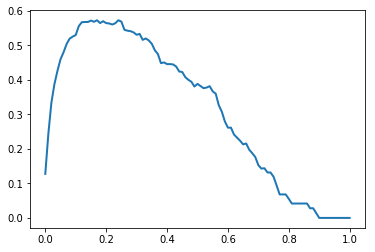

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


threshold 0.24
max f1_score 0.5724137931034482
eta 0.3
max_depth 2
num_round 35


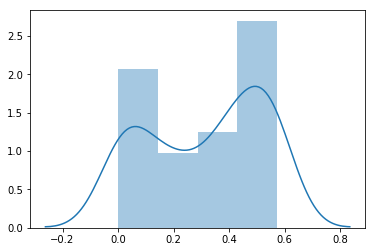

In [68]:
f1_sc = 0
max_step = 0
thr_sample = (dtest, test_y)
_score_preds = bst.predict(thr_sample[0], ntree_limit=bst.best_ntree_limit)
scores = []
for thr_step in np.linspace(0, 1, 101):
    _preds = predict(_score_preds, thr_step)
    f1_sc_step = f1_score(thr_sample[1], _preds)
    #print(thr_step, f1_sc_step)
    scores.append(f1_sc_step)
    if f1_sc_step >= f1_sc:
        f1_sc = f1_sc_step
        max_step = thr_step
plt.plot(np.linspace(0, 1, 101), scores, linewidth=2.0)
plt.show()
sns.distplot(scores)

threshold = max_step
print('threshold', threshold)
print('max f1_score', f1_sc)
print('eta', params['eta'])
print('max_depth', params['max_depth'])
print('num_round', bst.best_ntree_limit)

In [69]:
# make predictions on datasets
train_pred = predict(bst.predict(dtrain), threshold)
test_pred = predict(bst.predict(dtest), threshold)

cm_train = confusion_matrix(train_y, train_pred)
cm_test = confusion_matrix(test_y, test_pred)

cm_train_pct = cm_train / cm_train.astype(np.float).sum()*100
cm_test_pct = cm_test / cm_test.astype(np.float).sum()*100

summary = [
    ['------', 'Train', 'Test'],
    ['confusion matrix', cm_train, cm_test],
    ['confusion matrix pct', cm_train_pct, cm_test_pct],
    ['f1_score', f1_score(train_y, train_pred), f1_score(test_y, test_pred)],
    ['accuracy score', accuracy_score(train_y, train_pred), accuracy_score(test_y, test_pred)],
    ['recall score', recall_score(train_y, train_pred), recall_score(test_y, test_pred)],
    ['precision_score', precision_score(train_y, train_pred),  precision_score(test_y, test_pred)]
]

# print pretty table
print('thr', threshold)
print('iter', bst.best_ntree_limit)
pretty_table(summary)
print(params)


thr 0.24
iter 35
------              	Train                      	Test                       
confusion matrix    	[[7687  271]               	[[1864   66]               
                    	 [ 154  317]]              	 [  58   83]]              
confusion matrix pct	[[91.19705778  3.21509076] 	[[90.00482859  3.18686625] 
                    	 [ 1.82702574  3.76082572]]	 [ 2.80057943  4.00772574]]
f1_score            	0.5986779981114257         	0.5724137931034482         
accuracy score      	0.9495788349744928         	0.9401255432158377         
recall score        	0.673036093418259          	0.5886524822695035         
precision_score     	0.5391156462585034         	0.5570469798657718         
{'objective': 'binary:logistic', 'eta': 0.3, 'max_depth': 2, 'eval_metric': 'auc'}
